In [1]:
# !pip install -q git+https://github.com/samoturk/mol2vec;

In [2]:
# !pip install -q huggingface-hub transformers catboost xgboost lightgbm torch gensim==3.7.1

In [3]:
import gensim
print(gensim.__version__) # 3.7.1

3.7.1


In [1]:
# from typing import Any, Callable, Dict, Iterable, List, Tuple, Optional, Union
import pandas as pd
# import numpy as np
# import os
# import dgl
# import yaml

# from rdkit import Chem
# from rdkit.Chem import AllChem, DataStructs
# from mordred import Calculator, descriptors

# from huggingface_hub import snapshot_download
# from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM

# from mol2vec.features import MolSentence, DfVec, sentences2vec, mol2alt_sentence, mol2sentence
# from gensim.models import word2vec

from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.model_selection import train_test_split, KFold
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.svm import SVR
# from sklearn.linear_model import RidgeCV, LassoCV

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dropout, Dense
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow import keras
# import torch

# from catboost import CatBoostRegressor
# import xgboost as xgb
# import lightgbm as lgb
# import matplotlib.pyplot as plt

2024-04-20 12:49:19.589822: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-20 12:49:21.454465: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-20 12:49:21.454681: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-20 12:49:21.454699: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
from utils import PreprocessSMILES
from utils import SimpleRegressions
from utils import SmallNN
from utils import LstmRegressor


directory = './materials/'
preprocessor = PreprocessSMILES(directory, 'canonical_smiles')
mdf = preprocessor.preprocess_data("train_data_fix_concat.csv")
grouped_mdf = preprocessor.preprocess_mol2vec(mdf)
smiles_df = preprocessor.smiles2sentence(mdf)
joined_df = pd.merge(grouped_mdf, smiles_df, on='blend_id', how='inner').dropna() # TODO: fix nan
joined_df = preprocessor.embed_smiles(joined_df, 'DeepChem/ChemBERTa-10M-MTR') # ibm/MoLFormer-XL-both-10pct DeepChem/ChemBERTa-10M-MTR
mdf['graphs'] = preprocessor.generate_graphs(mdf)
# graph_df = mdf.copy()
# graph_df.drop(columns=['oil_property_param_title', 'oil_property_param_value', 'mol'], inplace=True)

X, y = preprocessor.xy_split(joined_df, column = 'embeddings')

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Some weights of the model checkpoint at ./materials/embed_model/DeepChem/ChemBERTa-10M-MTR/models--DeepChem--ChemBERTa-10M-MTR/snapshots/b65d0a6af3156071d9519e867d695aa265bb393f were not used when initializing RobertaModel: ['regression.dense.weight', 'regression.out_proj.weight', 'regression.out_proj.bias', 'norm_mean', 'regression.dense.bias', 'norm_std']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ./materials/embed_model/DeepChem/ChemBERTa-10M-MTR/models--DeepChem--ChemBERTa-10M-MTR/snapshots/b65d0

In [10]:
joined_df['similarity_vectors'][10]

[0.18518518518518517,
 0.16666666666666666,
 0.14285714285714285,
 0.15384615384615385,
 0.4444444444444444,
 0.375,
 0.5555555555555556,
 0.2857142857142857,
 0.4117647058823529,
 0.42857142857142855]

In [11]:
batched_graph = dgl.batch(mdf['graphs'].tolist())
batched_graph

Graph(num_nodes=12584, num_edges=22700,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'type': Scheme(shape=(1,), dtype=torch.float32)})

In [12]:
print(y.shape)
print(X.shape)

(338,)
(338, 384)


Catboost
0:	learn: 0.9704248	test: 0.9969330	best: 0.9969330 (0)	total: 904ms	remaining: 15m 3s
1:	learn: 0.9433136	test: 0.9752854	best: 0.9752854 (1)	total: 1.29s	remaining: 10m 46s
2:	learn: 0.9192126	test: 0.9509911	best: 0.9509911 (2)	total: 1.71s	remaining: 9m 27s
3:	learn: 0.8949258	test: 0.9291612	best: 0.9291612 (3)	total: 2.1s	remaining: 8m 42s
4:	learn: 0.8799084	test: 0.9180935	best: 0.9180935 (4)	total: 2.68s	remaining: 8m 54s
5:	learn: 0.8606966	test: 0.8971121	best: 0.8971121 (5)	total: 3.19s	remaining: 8m 49s
6:	learn: 0.8413167	test: 0.8688101	best: 0.8688101 (6)	total: 3.65s	remaining: 8m 38s
7:	learn: 0.8205868	test: 0.8556163	best: 0.8556163 (7)	total: 4.14s	remaining: 8m 33s
8:	learn: 0.8031038	test: 0.8412555	best: 0.8412555 (8)	total: 4.63s	remaining: 8m 29s
9:	learn: 0.7881098	test: 0.8337549	best: 0.8337549 (9)	total: 5.14s	remaining: 8m 28s
10:	learn: 0.7760970	test: 0.8253830	best: 0.8253830 (10)	total: 5.73s	remaining: 8m 35s
11:	learn: 0.7641788	test: 0.819

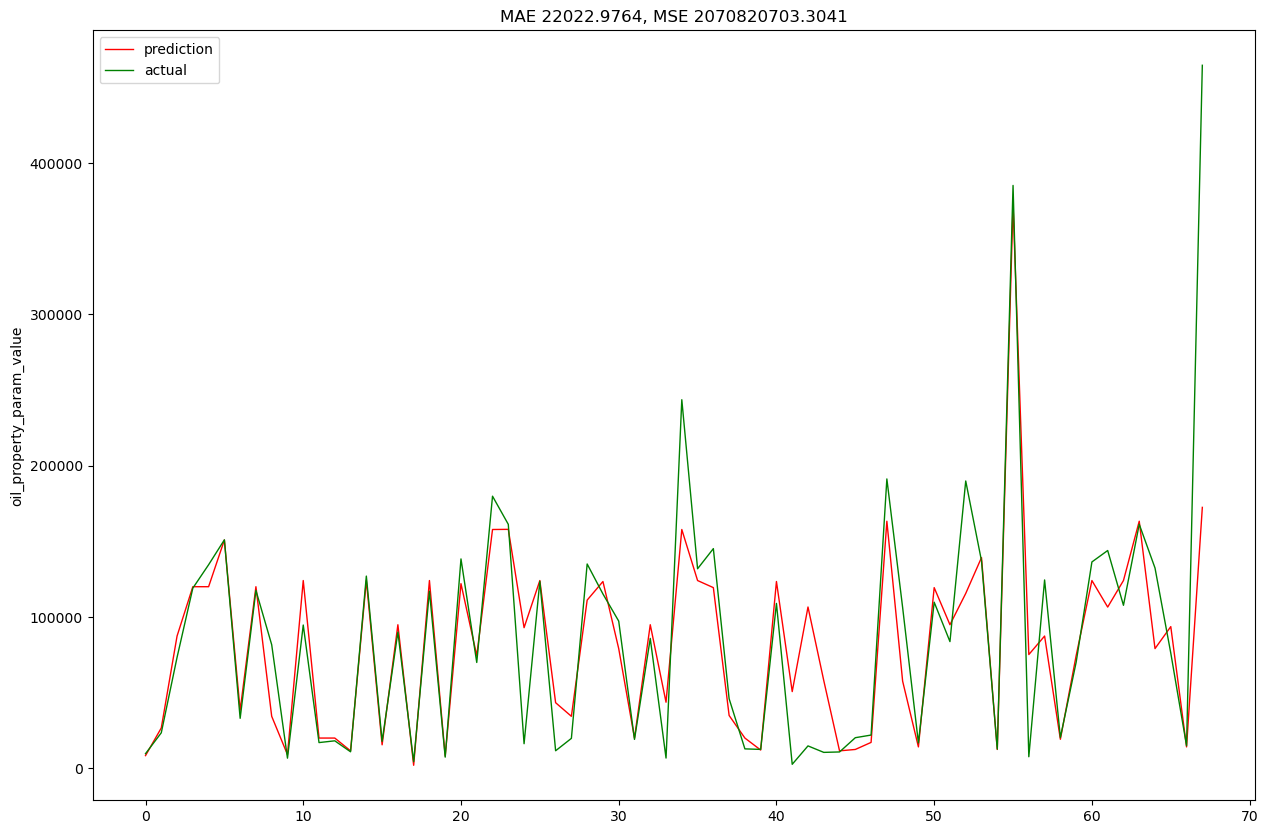

MAE score: 22022.9764
MSE score: 2070820703.3041
RandomForestRegressor


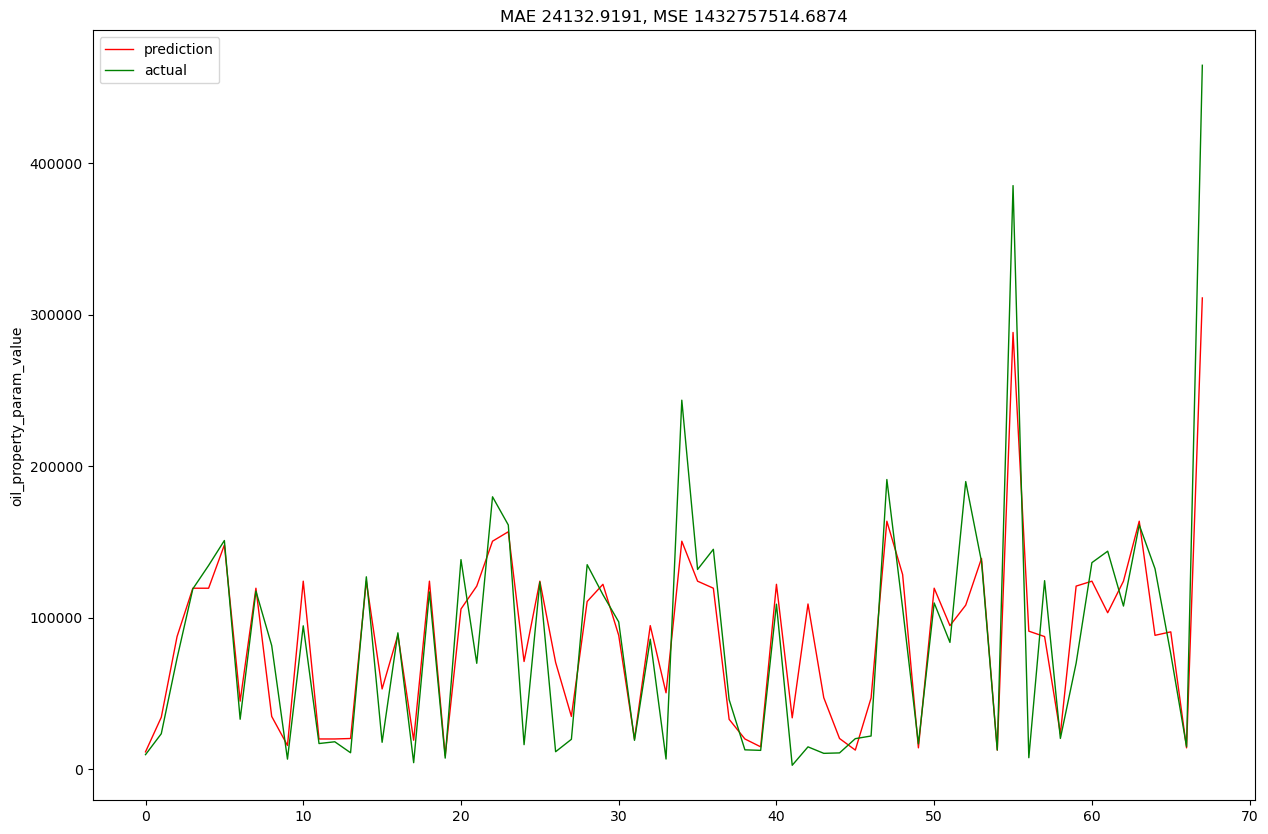

MAE score: 24132.9191
MSE score: 1432757514.6874
XGBRegressor


/home/karnaksp/miniconda3/envs/myenv/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-rmse:0.97437
[1]	validation_0-rmse:0.90270
[2]	validation_0-rmse:0.83874
[3]	validation_0-rmse:0.77755
[4]	validation_0-rmse:0.72392
[5]	validation_0-rmse:0.67633
[6]	validation_0-rmse:0.63229
[7]	validation_0-rmse:0.59461
[8]	validation_0-rmse:0.56018
[9]	validation_0-rmse:0.52805
[10]	validation_0-rmse:0.49781
[11]	validation_0-rmse:0.47243
[12]	validation_0-rmse:0.45029
[13]	validation_0-rmse:0.43045
[14]	validation_0-rmse:0.41329
[15]	validation_0-rmse:0.39925
[16]	validation_0-rmse:0.38689
[17]	validation_0-rmse:0.37522
[18]	validation_0-rmse:0.36458
[19]	validation_0-rmse:0.35611
[20]	validation_0-rmse:0.34897
[21]	validation_0-rmse:0.34166
[22]	validation_0-rmse:0.33709
[23]	validation_0-rmse:0.33277
[24]	validation_0-rmse:0.32839
[25]	validation_0-rmse:0.32486
[26]	validation_0-rmse:0.32127
[27]	validation_0-rmse:0.31839
[28]	validation_0-rmse:0.31595
[29]	validation_0-rmse:0.31353
[30]	validation_0-rmse:0.31100
[31]	validation_0-rmse:0.30865
[32]	validation_0-

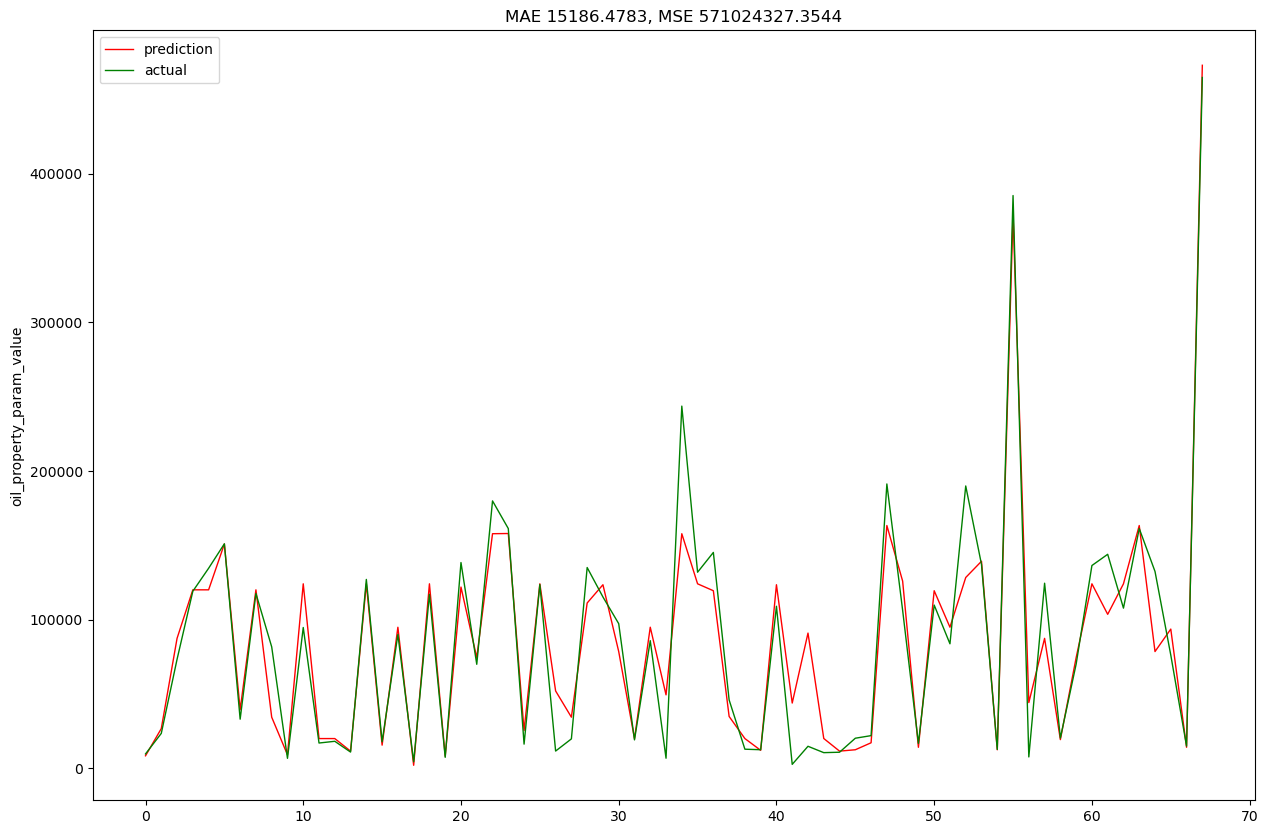

MAE score: 15186.4783
MSE score: 571024327.3544
LGBMRegressor
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22996
[LightGBM] [Info] Number of data points in the train set: 270, number of used features: 384
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

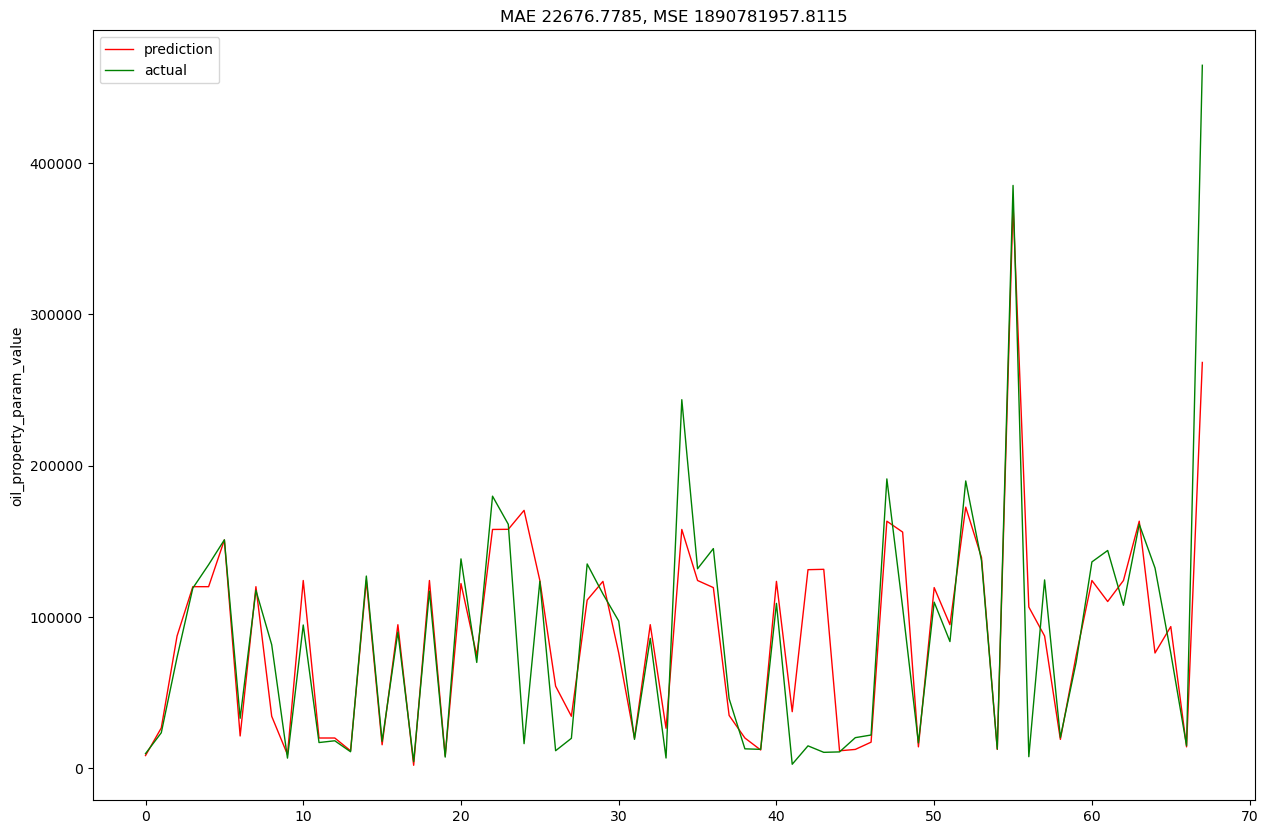

MAE score: 22676.7785
MSE score: 1890781957.8115
GradientBoostingRegressor


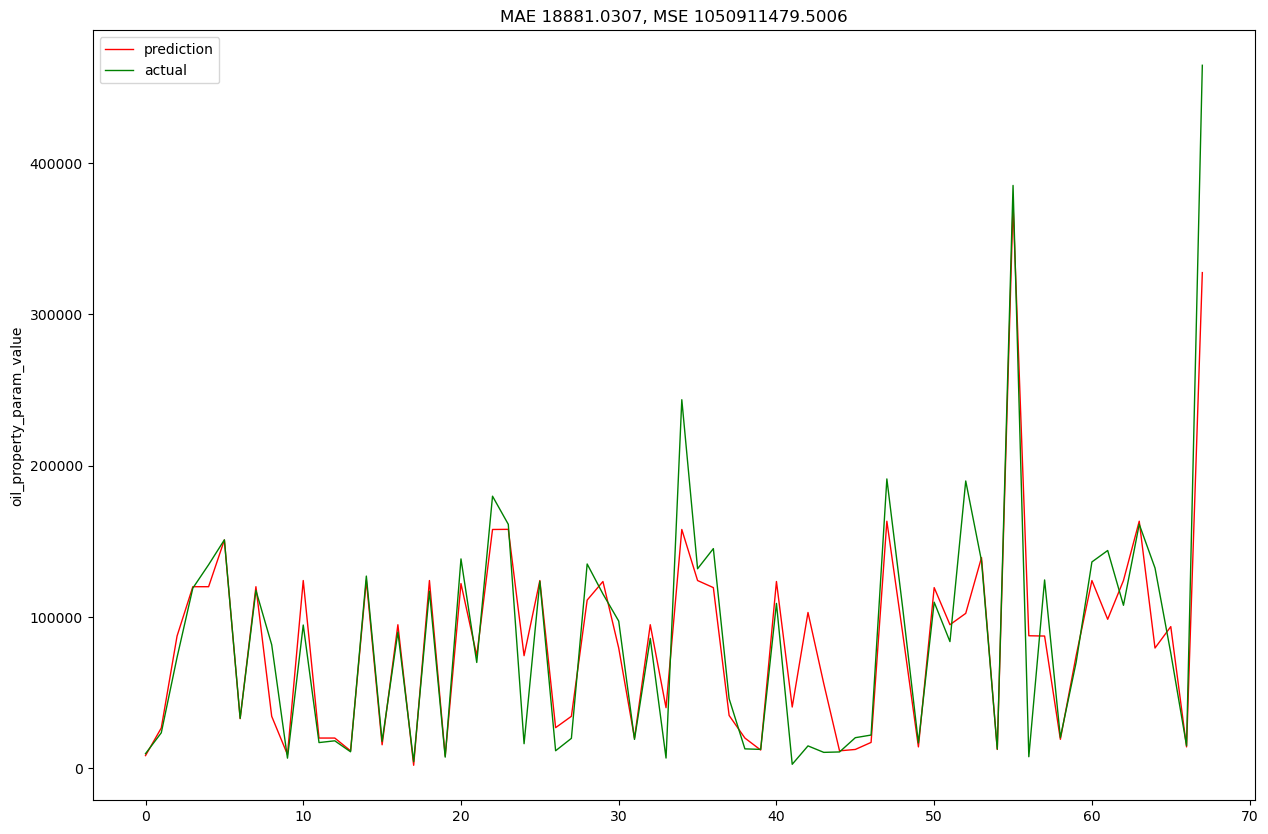

MAE score: 18881.0307
MSE score: 1050911479.5006
SVR


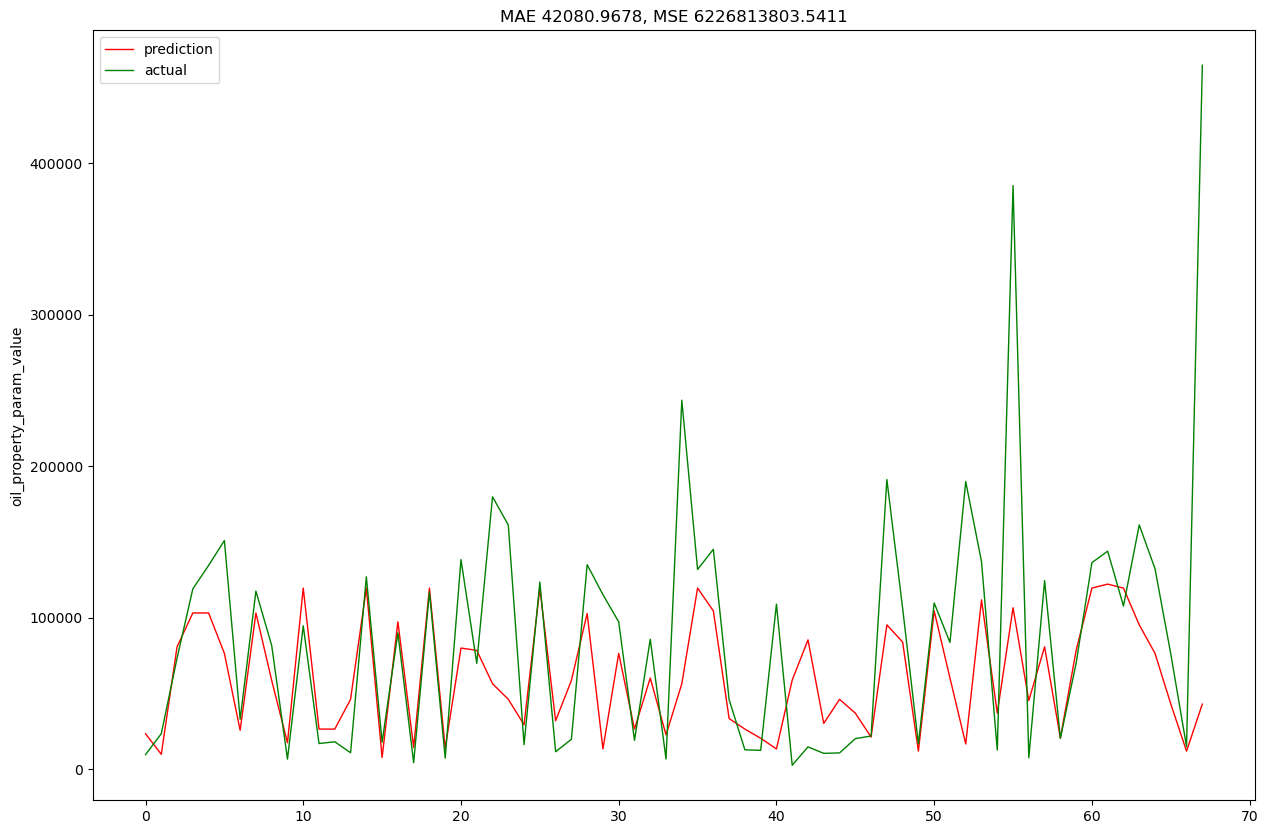

MAE score: 42080.9678
MSE score: 6226813803.5411


In [13]:

regression_models = SimpleRegressions(X, y)
regression_models.fit_and_evaluate()



2024-04-20 13:23:33.876819: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-20 13:23:33.877382: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-20 13:23:33.877930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-HPESRLBL): /proc/driver/nvidia/version does not exist
2024-04-20 13:23:33.887437: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/400
4/4 [==============================] - 2s 103ms/step - loss: 0.0217 - mean_absolute_error: 0.1035 - val_loss: 0.0079 - val_mean_absolute_error: 0.0674 - lr: 0.0010
Epoch 2/400
4/4 [==============================] - 0s 27ms/step - loss: 0.0159 - mean_absolute_error: 0.0794 - val_loss: 0.0084 - val_mean_absolute_error: 0.0753 - lr: 0.0010
Epoch 3/400
4/4 [==============================] - 0s 16ms/step - loss: 0.0140 - mean_absolute_error: 0.0815 - val_loss: 0.0048 - val_mean_absolute_error: 0.0579 - lr: 0.0010
Epoch 4/400
4/4 [==============================] - 0s 15ms/step - loss: 0.0121 - mean_absolute_error: 0.0633 - val_loss: 0.0049 - val_mean_absolute_error: 0.0562 - lr: 0.0010
Epoch 5/400
4/4 [==============================] - 0s 19ms/step - loss: 0.0112 - mean_absolute_error: 0.0598 - val_loss: 0.0047 - val_mean_absolute_error: 0.0583 - lr: 0.0010
Epoch 6/400
4/4 [==============================] - 0s 17ms/step - loss: 0.0105 - mean_absolute_error: 0.0627 - val_loss: 0.0

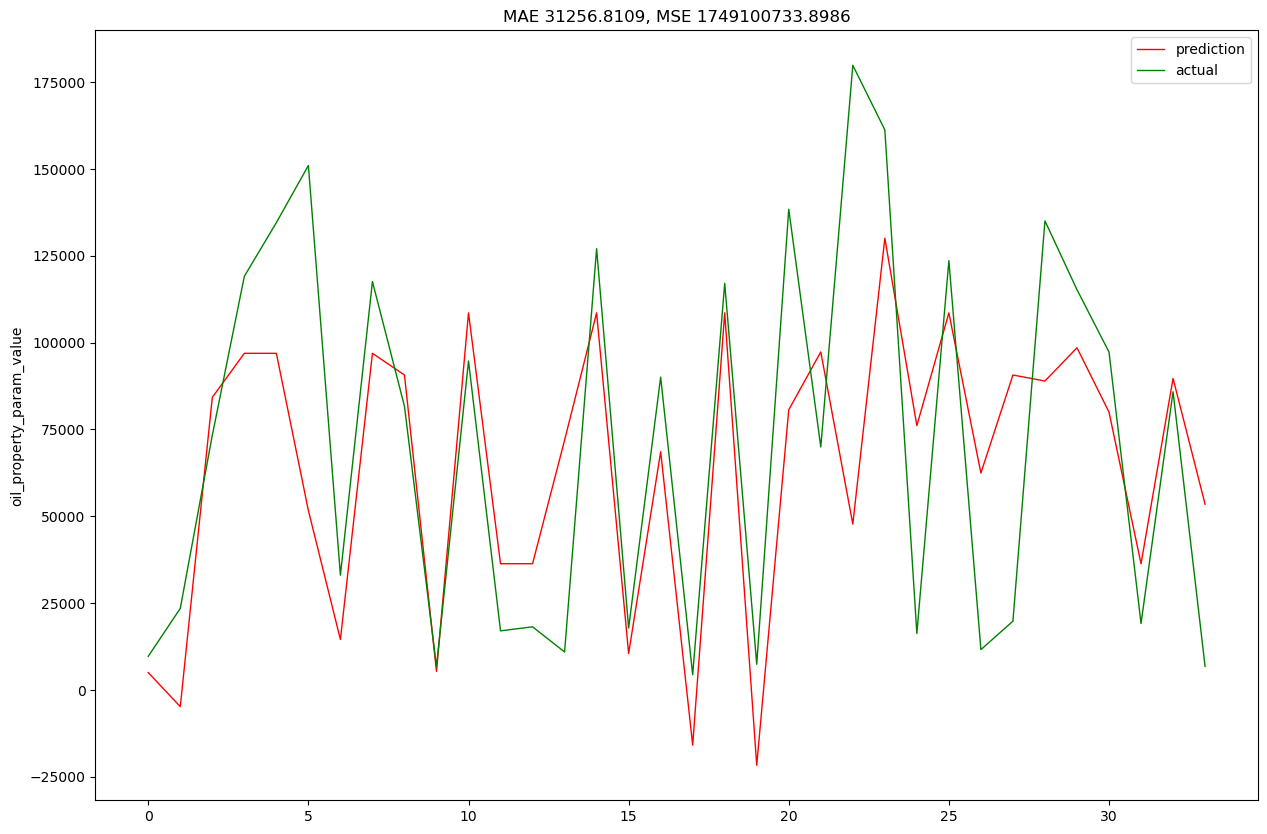

MAE score: 31256.8109
MSE score: 1749100733.8986


In [14]:
nn_model = SmallNN(X, y)
nn_model.fit_and_evaluate()


Epoch 1/20
5/5 [==============================] - 18s 2s/step - loss: 1.0033 - val_loss: 1.0000 - lr: 0.0010
Epoch 2/20
5/5 [==============================] - 9s 2s/step - loss: 1.0075 - val_loss: 1.0001 - lr: 0.0010
Epoch 3/20
5/5 [==============================] - 9s 2s/step - loss: 1.0016 - val_loss: 0.9999 - lr: 0.0010
Epoch 4/20
5/5 [==============================] - 8s 2s/step - loss: 1.0019 - val_loss: 1.0000 - lr: 0.0010
Epoch 5/20
5/5 [==============================] - 9s 2s/step - loss: 1.0024 - val_loss: 0.9999 - lr: 0.0010
Epoch 6/20
5/5 [==============================] - 8s 2s/step - loss: 1.0021 - val_loss: 0.9998 - lr: 0.0010
Epoch 7/20
5/5 [==============================] - 8s 2s/step - loss: 1.0008 - val_loss: 0.9998 - lr: 0.0010
Epoch 8/20
5/5 [==============================] - 8s 2s/step - loss: 0.9994 - val_loss: 0.9998 - lr: 0.0010
Epoch 9/20
5/5 [==============================] - 8s 2s/step - loss: 1.0022 - val_loss: 0.9997 - lr: 0.0010
Epoch 10/20
5/5 [==========

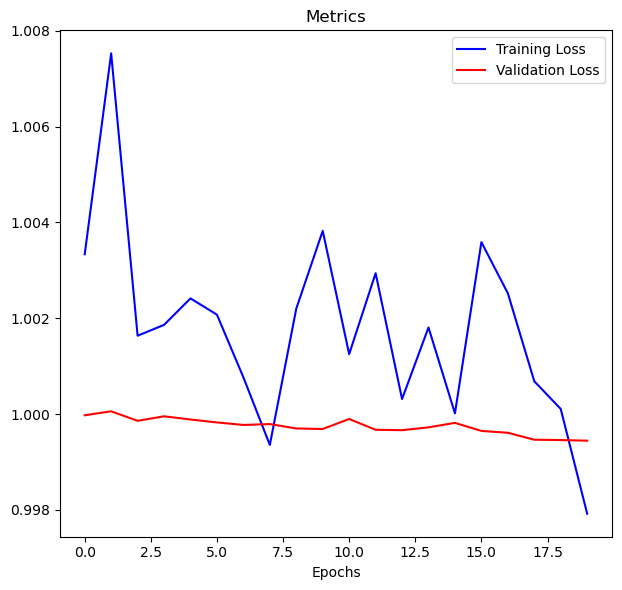

1/1 [==============================] - 2s 2s/step


In [15]:
scaler_ = StandardScaler() # RobustScaler
regressor = LstmRegressor(units=50, dropout_rate=0.2, optimizer='rmsprop', epochs=20, 
                          batch_size=64, neurons_1 = 128, neurons_2 = 64, scaler=scaler_)

X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.1, random_state=42
        )
model, _ = regressor.fit(X_train, y_train, X_test, y_test)